# Understanding the IMT dataset

Author: Stephan

One of the datasets we got from PE gives us information about supply and demand for a given job, department and point in time. 

* supply: number of open position for a job
* demand: number of people looking for this job

These values are always averaged over the last 12 months, probably to average out seasonal effects. It came with documentation in french which explains the columns as:

* DPT: Department code
* ROME: Rome code - This is the code of the job_group
* DE: Average^* number of entries on employment center lists into categories A, B, C over the last 12 months
* OFF: Average^* number of job vacancies registered at employment center in the last 12 months
* MOIS: month - each of these indicators is averaged over the last 12 months (eg the data for November 2015 is an average between beginning of October 2014 and the end of October 2015).

`*` The following document is an attempt to get a better understanding of how these numbers are computed. Above mentiond the *average* number of entries, but we are not sure what this average is over. Are they using the average number of days, or the average value at the end of a month?

In [2]:
import datetime
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sas7bdat import SAS7BDAT

# the data loading is pretty slow and execution of this cell my take a few minutes
imt = pd.read_csv('../../data/imt/IMT.csv', sep=';', low_memory=False)
fhs = SAS7BDAT('../../data/pole_emploi/FHS/FHS BI 201412/Reg116/de_201412_echant.sas7bdat').to_data_frame()

In [3]:
imt.head()

,dpt,ROME,off,de,mois
0,01,A1101,1.22,2.78,201101
1,01,A1101,1.13,3.00,201102
2,01,A1101,1.14,2.86,201103
3,01,A1101,1.13,2.63,201104
4,01,A1101,1.25,2.63,201105


To get an overview of the dataset, let's look at the number of individual ROME codes, the number of departements and the time frame for which we got the data.

In [4]:
imt['mois_date'] = pd.to_datetime(imt.mois, format='%Y%m')

data from 100 different departments
data for 530 different ROME codes


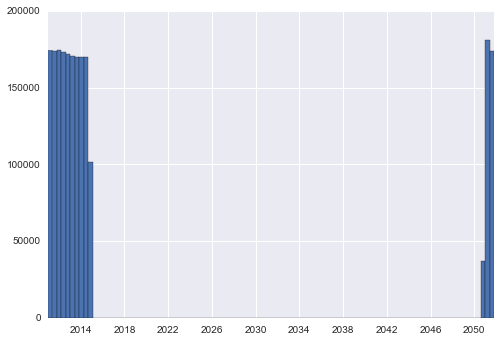

In [5]:
print('data from {} different departments'.format(imt.dpt.nunique()))
print('data for {} different ROME codes'.format(imt.ROME.nunique()))
_ = imt.mois_date.hist(bins=100)

And woooooow, we got data from the future!

In [6]:
imt.mois_date.max()

Timestamp('2051-11-01 00:00:00')

**That looks as if there is a typo in the data. Probably 2015 got mixed up with 2051. For the rest of the document I will only look at pre 2014 data.**

In [7]:
imt = imt[imt.mois_date < '2015']

### Offer and demand distribution

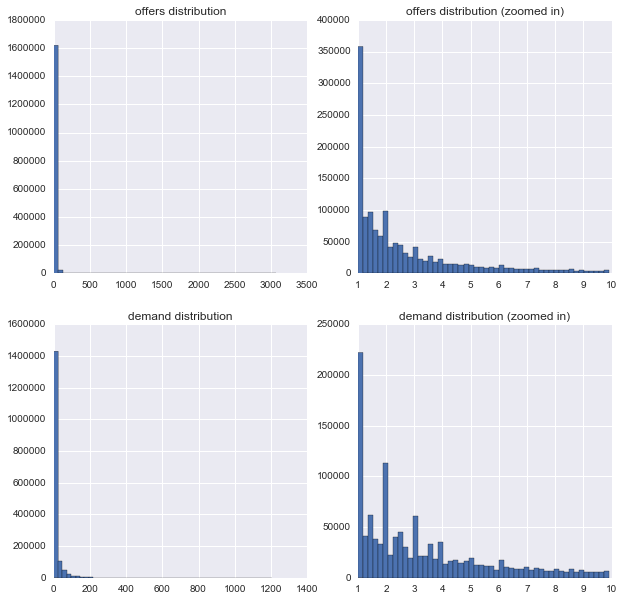

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax = imt.off.hist(bins=50, ax=axs[0,0])
ax.set_title('offers distribution')
ax = imt[imt.off < 10].off.hist(bins=50, ax=axs[0,1])
ax.set_title('offers distribution (zoomed in)')

ax = imt.de.hist(bins=50, ax=axs[1,0])
ax.set_title('demand distribution')
ax = imt[imt.de < 10].de.hist(bins=50, ax=axs[1,1])
ax.set_title('demand distribution (zoomed in)')
pass

In [9]:
print("minimum value for offers: {}".format(imt.off.min()))
print("minimum value for demand: {}".format(imt.de.min()))

minimum value for offers: 1.0
minimum value for demand: 1.0


That is strange! Why is the minimum for average number of offers or demand exactly equal to 1.0? That would mean that there is always at least one person looking for a specific job in each department over the last 12 months!? I don't understand why that would be the case.

### Average supply and demand per ROME

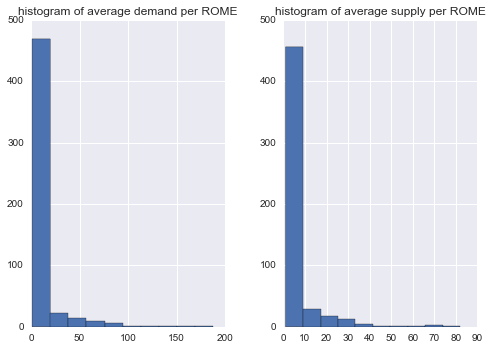

In [10]:
mean_per_rome = imt.groupby('ROME')[['off', 'de']].mean()
ax = mean_per_rome.hist().flatten()
ax[0].set_title("histogram of average demand per ROME")
ax[1].set_title("histogram of average supply per ROME")
pass

let's pick some rome codes from the medium range

In [11]:
middle_range = mean_per_rome[(mean_per_rome.de > 30) & (mean_per_rome.de < 40)]
middle_range

,off,de
ROME,,
D1208,11.444650,32.428817
D1211,9.551758,35.437667
G1801,13.126258,38.494375
H2909,14.611729,30.722346
I1203,26.857123,31.864079
M1604,8.025832,33.308496
N1101,14.071590,35.638133


**G1801** (Barman / Barmaid) seems to be a job in the higher demand range.

## Attempt to recompute IMT numbers from the FHS dataset

To better understand how the IMT demand numbers are calculated, I will try to recompute the demand number for **G1801** (Barman / Barmaid) for Paris for the twelve month previous to `201401`

In [12]:
print(fhs.shape)
fhs.head().transpose()

(1132981, 39)


,0,1,2,3,4
IDX,7,23,40,42,51
NDEM,1,1,1,1,2
SEXE,1,2,1,1,1
datnais,1945-03-15,1947-10-15,1947-12-15,1947-12-15,1949-10-15
DEPCOM,91179,91080,91174,91421,91386
NENF,2,0,3,2,0
NATION,01,01,49,01,01
NIVFOR,NV5,CFG,AFS,CFG,CFG
DIPLOME,D,N,N,N,N
SITMAT,M,M,M,M,C


In [13]:
barman_in_paris = imt[(imt.dpt == '75') & (imt.ROME == 'G1801') & (imt.mois == 201401)]
barman_in_paris

,dpt,ROME,off,de,mois,mois_date
1517974,75,G1801,58.08,171.33,201401,2014-01-01


So **171.33** is the number I will try to reproduce

In [14]:
# according to the data dictionary, the department code is identified by the firt two characters of DEPCOM
fhs['department_code'] = fhs.DEPCOM.map(lambda x: x[:2])

In [15]:
# This corresponds to the new categories A, B and C, indicating that a person id available to take a new job
available_for_work = ['1', '2', '3']
interesting_columns = ['ROME', 'DATINS', 'DATANN', 'DEPCOM', 'CATREGR']

fhs_barman_in_paris = fhs[(fhs.department_code == '75') & 
                          (fhs.ROME == 'G1801') & 
                          (fhs.CATREGR.isin(available_for_work))].copy()
fhs_barman_in_paris = fhs_barman_in_paris[interesting_columns]
fhs_barman_in_paris['start_date'] = pd.to_datetime(fhs_barman_in_paris.DATINS)
fhs_barman_in_paris['end_date'] = pd.to_datetime(fhs_barman_in_paris.DATANN)
fhs_barman_in_paris.drop(['DATINS', 'DATANN'], axis=1, inplace=True)

In [16]:
fhs_barman_in_paris.head()

,ROME,DEPCOM,CATREGR,start_date,end_date
225629,G1801,75110,2,2010-01-20,2014-02-25
227790,G1801,75118,1,2000-03-15,2006-02-28
227916,G1801,75117,1,2004-05-30,2005-01-01
228110,G1801,75112,1,2004-12-06,NaT
229915,G1801,75118,1,2010-12-22,2014-01-02


My understanding of how the IMT demand numbers are computed from FHS is that we want to compute

> how many people were on average looking for a specific job in a specific departement over a given period of 12 months

To do so I will

* select applications for a specific ROME code and department
* select applications that were active during the period in question (application end_date after beginning of period and application start_date before the end of the period
* select only applications from categories A, B and C (available for work)
* for each application compute how many days this person was looking for a job within the period
* sum the 'number of days in period' over all applications and divide it by 365 ==> this should give the average number of people looking for a job over the whole period.

Average demand over period for barman in Paris is 91.26


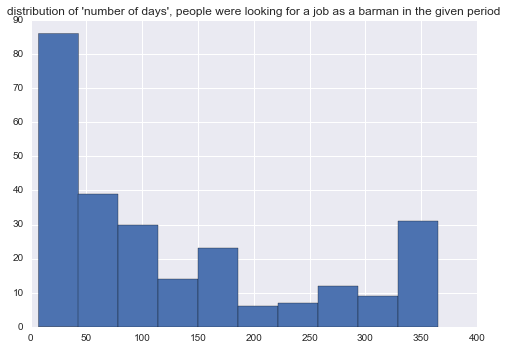

In [17]:
test = fhs_barman_in_paris
period_start = pd.to_datetime('2013-01-01')
period_end = pd.to_datetime('2013-12-31')

in_period = test[(test.end_date > period_start) & (test.start_date < period_end)].copy()
in_period['first_date_in_period'] = in_period.start_date.map(lambda x: max(x, period_start))
in_period['last_date_in_period'] = in_period.end_date.map(lambda x: min(x, period_end))
# add one day (to make being enrolled and unenrolled on the same day count as 1 day instead of 0)
in_period['duration'] = in_period.last_date_in_period - in_period.first_date_in_period + datetime.timedelta(days=1)
avg_demand_period = in_period.duration.dt.days.sum() / 365
print("Average demand over period for barman in Paris is {:.2f}".format(avg_demand_period))
ax = in_period.duration.astype('timedelta64[D]').hist()
_ = ax.set_title("distribution of 'number of days', people were looking for a job as a barman in the given period")

There seems to be something wrong with my computation. I had expected a value of 171.33 for Barman in Paris, but my result is 90.56. 

## How did supply and demand change over time?

For a Barman in Paris

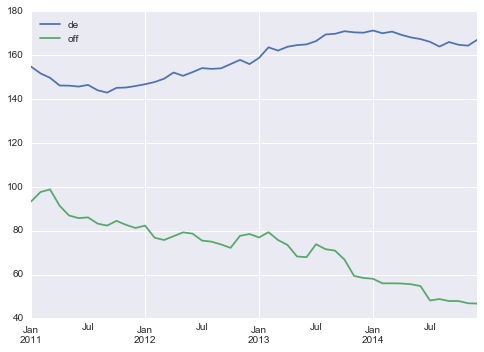

In [18]:
ts = imt[(imt.dpt == '75') & (imt.ROME == 'G1801')].copy()
ts.set_index(pd.DatetimeIndex(ts.mois_date), inplace=True)
_ = ts[['de', 'off']].plot()

#### Same numbers for a few random rome codes and random departements

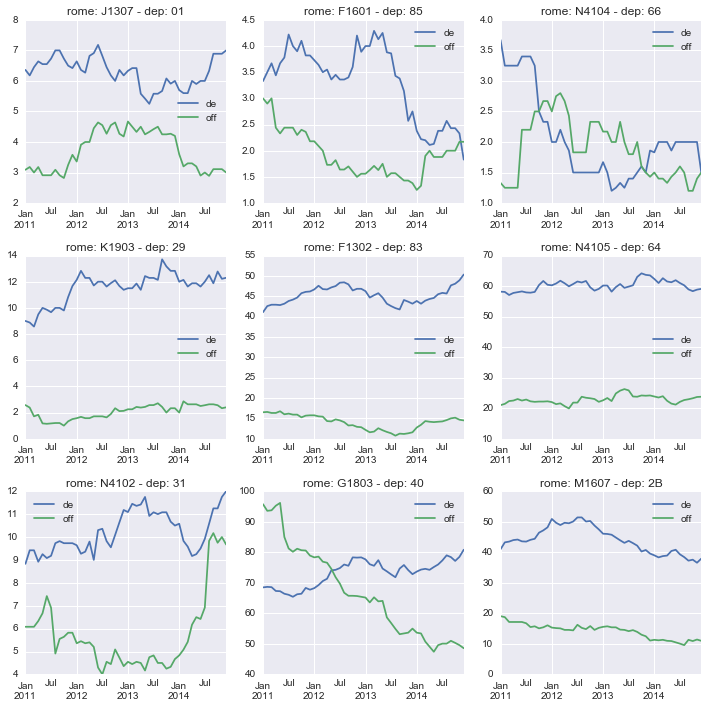

In [19]:
random_romes = imt.ROME.sample(9, random_state=42).values
random_departments = imt.dpt.sample(9, random_state=42).values
random_tuples = zip(random_romes, random_departments)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for i, (rome, department) in enumerate(random_tuples):
    ts = imt[(imt.dpt == department) & (imt.ROME == rome)]
    ts.set_index(pd.DatetimeIndex(ts.mois_date), inplace=True)
    if len(ts):
        ax = ts[['de', 'off']].plot(ax=axs[i])
        ax.set_title("rome: {} - dep: {}".format(rome, department))
fig.tight_layout()

Those numbers look generally ok, the curves are smooth and there are no weird jumps or anything.

## Summary

* There is a typo in the `mois` field of the IMT table. The year 2015 is accidentially called 2051
* The minimum value for offers and demand (per department and ROME and period) is 1.0. I don't understand why the minimum value is not 0.0 and why *exactly one person looking for a job for the whole 12 months* appears that often.
* We are not able to re-compute the IMT values from the FHS table, we need further information about how the IMT demand numbers are computed.